# <center> Lecture11 : Evaluating Regression Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

在lec10的末尾，我们引入了是否吸烟这个变量，并建立了一个新的回归模型

在本节课中，我们仍然会使用这个模型，并在该模型上进行扩充

## 模型回顾

首先简单回顾一下对此模型的定义：

* 在这个例子中，我们将是否吸烟作为自变量，将自我控制分数作为因变量

    * 在自变量中，`0` 表示不吸烟，`1`表示吸烟

$$
X_{i2} = \begin{cases}
1 & \text{Yes} \\
0 & \text{No} \\
\end{cases}
$$

* 两种情况下，自我控制分数分布的密度图


![Image Name](https://cdn.kesci.com/upload/s40nk3kagu.png?imageView2/0/w/960/h/960)

In [ ]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 筛选站点为"Tsinghua"的数据
df_METU = df_raw[df_raw["Site"] == "METU"]

# 选择需要的两列
df_METU = df_METU[["stress","scontrol","smoke"]]

#1 表示吸烟，2表示不吸烟
df_METU["smoke"] =  np.where(df_METU['smoke'] == 2, 0, 1)
df_METU["smoke_recode"] =  np.where(df_METU['smoke'] == 1, "yes", "no")

#设置索引
df_METU["index"] = range(len(df_METU))
df_METU = df_METU.set_index("index")

### 模型定义

* 根据吸烟和自我控制之间的关系建立一个正态回归模型：

$$
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_2 X_{i2}\\
\text{priors:} & & \beta_{0}  &  \sim N\left(60, 2^2\right)  \\
                     & & \beta_1  & \sim N\left(-10, 4^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}

$$

**在这个例子中，各参数的意义：**

* $\beta_0  =  \beta_0 + \beta_2 \cdot 0$

    * 当$X_{i2} = 0$时，$\mu_i$的取值。 $\beta_0 $ 表示不吸烟情况下，自我控制分数的均值

* $\beta_0 + \beta_2 \cdot 1 = \beta_0 + \beta_2 $

    * $\beta_2 $ ：当$X_{i2} = 1$时，$\mu_i$的取值。表示吸烟情况下，自我控制分数的均值，则$\beta_2 $表示了从不吸烟到吸烟，自我控制分数的变化程度

* 这里我们还是根据经验定义先验中的超参

**快速运行模型定义、后验参数采样、后验预测分布部分**

In [ ]:
with pm.Model() as category_model:

    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=-10, sigma=4)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")
    mu = pm.Deterministic("mu", beta_0 + beta_1*smoke, dims="obs_id")                           #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [ ]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with category_model:
    cat_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 79 seconds.


In [ ]:
with category_model:
    cat_ppc = pm.sample_posterior_predictive(cat_regression,
                                             random_seed=84735) 

Sampling: [y_est]


### 评估后验预测

* 这里我们仍然使用上节课介绍过的两个指标：**MAE**与**后验预测区间**。这里不再做具体介绍。

* 这里不再展示具体的代码，简单展示输出的结果

![Image Name](https://cdn.kesci.com/upload/s4behs84tf.PNG?imageView2/0/w/960/h/960)

#### MAE
$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [ ]:
from statistics import median
# 计算每个X取值下对应的后验预测模型的均值
cat_pre_x = cat_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
cat_pre_y_mean = cat_pre_x.mean(axis=1).values

# 提取观测值Y，提取对应Y值下的后验预测模型的均值
cat_MAE = pd.DataFrame({
    "scontrol_ppc_mean": cat_pre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
cat_MAE["pre_error"] = cat_MAE["scontrol_original"] -\
                         cat_MAE["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_cat = median(cat_MAE.pre_error)
print(f"计算得到的MAE: {MAE_cat:.2f}")

计算得到的MAE: -1.27


#### 后验预测区间

In [ ]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_cat = az.summary(cat_ppc)
hdi_cat = hdi_cat.reset_index()

# 将原数据中的自我控制分数合并，便于后续进行判断
hdi_cat["y_obs"] = cat_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_cat["verify"] = np.where((hdi_cat["y_obs"] >= hdi_cat["hdi_3%"]) & (hdi_cat["y_obs"] <= hdi_cat["hdi_97%"]), 
                  0, 1)
hdi_cat_num = sum(hdi_cat["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_cat_num}")

所有超过后验预测范围HDI的数量: 10


### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

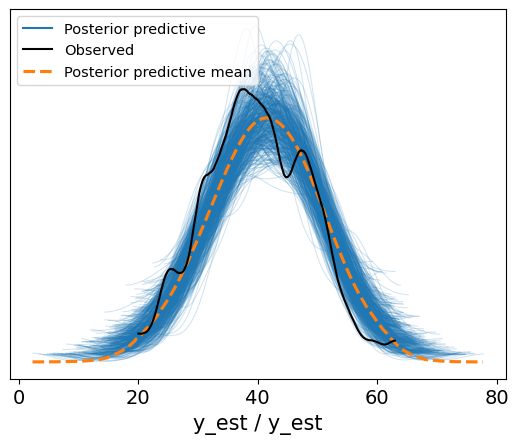

In [ ]:
az.plot_ppc(cat_ppc, num_pp_samples=500)

## 增加预测变量

* 我们可以将吸烟情况和压力作为不同的自变量，加入到模型中来

* 基于吸烟情况，绘制原数据中压力和自我控制的关系

![Image Name](https://cdn.kesci.com/upload/s49oqb24we.png?imageView2/0/w/960/h/960)

### 模型定义

$$  
 
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\
\text{priors:} & & \beta_{0}  & \sim N\left(60, 2^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\ 
                    & & \beta_2  & \sim N\left(-10, 4^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  

$$  

**在这个例子中，各参数的意义：**

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 0 = \beta_0 + \beta_1X_{i1}$

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 1 = (\beta_0 + \beta_2) + \beta_1X_{i1}$

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 这里我们还是根据经验定义先验中的超参

**直接运行模型定义、MCMC采样、后验预测部分**

In [ ]:
with pm.Model() as multi_linear_model:

    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=-10, sigma=4)
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    stress = pm.MutableData("stress",df_METU.stress, dims="obs_id")                     #x是自变量压力水平
    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*smoke, dims="obs_id")                             #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [ ]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with multi_linear_model:
    multi_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 103 seconds.


In [ ]:
with multi_linear_model:
    multi_ppc = pm.sample_posterior_predictive(multi_regression,
                                             random_seed=84735) 

Sampling: [y_est]


### 可视化后验预测结果

#### 后验预测的线性模型

我们可以分别查看**吸烟情况**与**压力**对**自我控制**的预测情况

1. $\mu_i = \beta_0 + \beta_1X_{i1}$：自我控制分数随压力分数变化的情况

2. $\mu_i = \beta_0 + \beta_2X_{i2}$：自我控制分数随吸烟变化的情况


In [ ]:
# 将参数beta_0, beta_1 与自变量 压力分数 进行组合，生成回归线
multi_regression.posterior["stress_ymodel"] = multi_regression.posterior["beta_0"] +\
                                              multi_regression.posterior["beta_1"] * multi_regression.constant_data["stress"]

# 将参数beta_0, beta_2 与自变量 吸烟情况 进行组合，生成回归线
multi_regression.posterior["smoke_ymodel"] = multi_regression.posterior["beta_0"] +\
                                              multi_regression.posterior["beta_2"] * multi_regression.constant_data["smoke"]

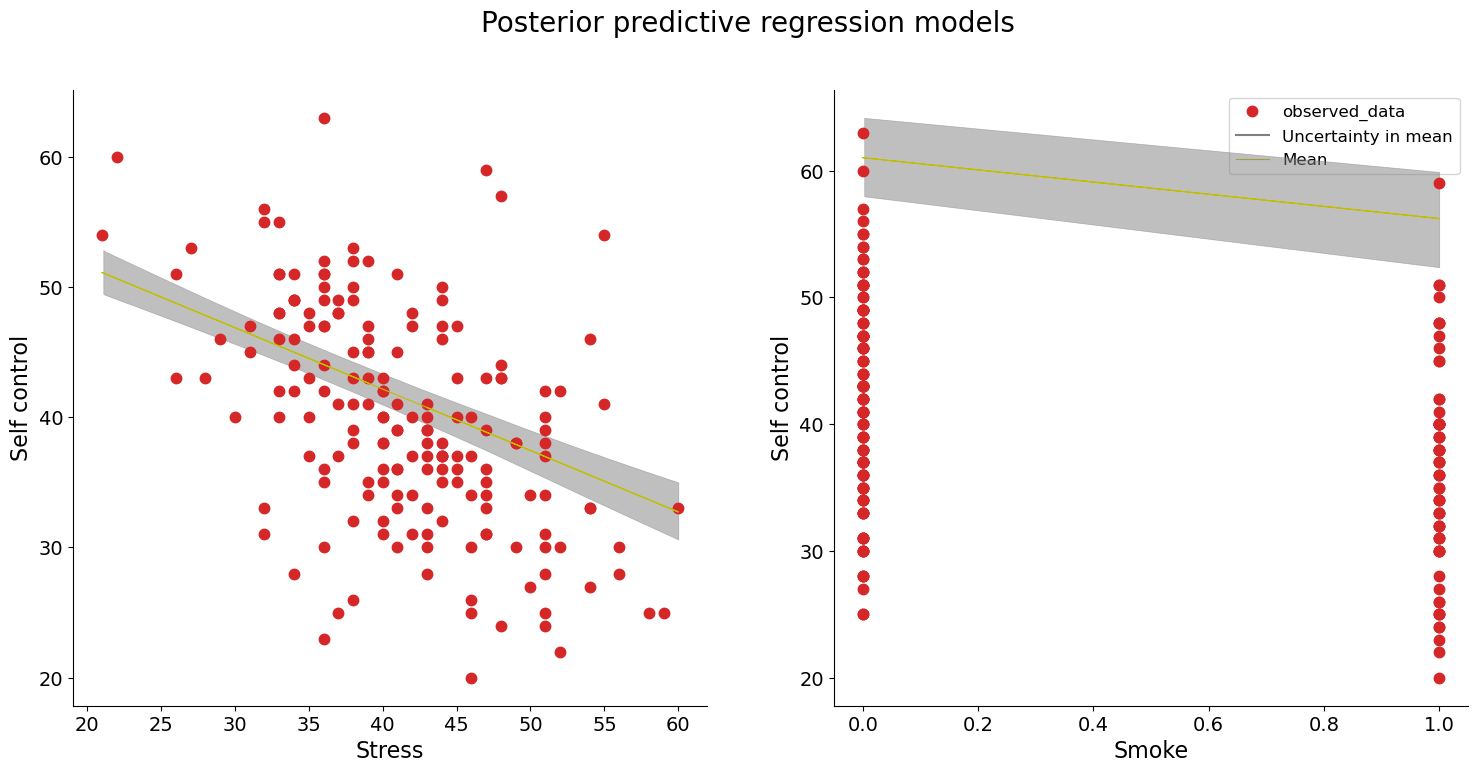

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(18, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=multi_regression,
           y= "y_est",
           x= "stress",
           y_model = multi_regression.posterior["stress_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[0],
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})
#设置坐标轴标题
axes[0].set_xlabel('Stress', fontsize=16) 
axes[0].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=multi_regression,
           y= "y_est",
           x= "smoke",
           y_model = multi_regression.posterior["smoke_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[1],
           y_model_fill_kwargs = {"color":"grey"})

#设置坐标轴标题
axes[1].set_xlabel('Smoke', fontsize=16) 
axes[1].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
# 设置坐标轴字体大小、图例位置、总标题
axes[0].tick_params(labelsize=14)  
axes[1].tick_params(labelsize=14)
axes[1].legend(loc="upper right", fontsize=12)

fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

#### 基于吸烟状况，绘制压力对自我控制影响的回归模型(可自行练习)

In [ ]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df_METU.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df_METU.query("smoke == 1")["stress"])["index"].values

In [ ]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
nosmoke_para = multi_regression.sel(obs_id=no_smoke_index)
smoke_para = multi_regression.sel(obs_id=smoke_index)

In [ ]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
nosmoke_para.posterior["y_model"] = nosmoke_para.posterior["beta_0"] +\
                                    nosmoke_para.posterior["beta_1"] * nosmoke_para.constant_data["stress"] +\
                                    nosmoke_para.posterior["beta_2"] * nosmoke_para.constant_data["smoke"]


In [ ]:
# 在吸烟情况下，将参数与自变量进行组合，生成回归线
smoke_para.posterior["y_model"] = smoke_para.posterior["beta_0"] +\
                                  smoke_para.posterior["beta_1"] * smoke_para.constant_data["stress"] +\
                                  smoke_para.posterior["beta_2"] * smoke_para.constant_data["smoke"]


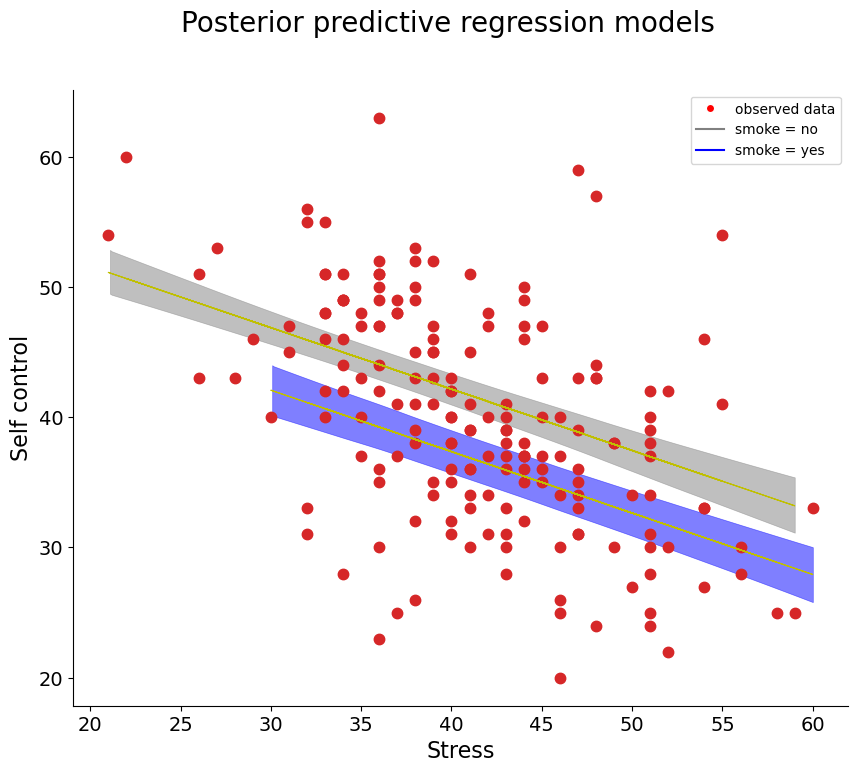

In [ ]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=nosmoke_para,
           y= "y_est",
           x= "stress",
           y_model = nosmoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=smoke_para,
           y= "y_est",
           x= "stress",
           y_model = smoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           y_model_fill_kwargs = {"color":"blue"},
           legend=False)

#设置坐标轴标题
axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Self control', fontsize=16) 

#设置图例
handles = [plt.Line2D([0], [0],
                      marker ='o',
                      color='w', 
                      markerfacecolor='red', 
                      label = 'observed data'),
           plt.Line2D([], [], color="grey",
                      label = 'smoke = no'),
           plt.Line2D([], [], color="blue",
                      label = 'smoke = yes')]

axes.legend(handles=handles)
#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14)  
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

#### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

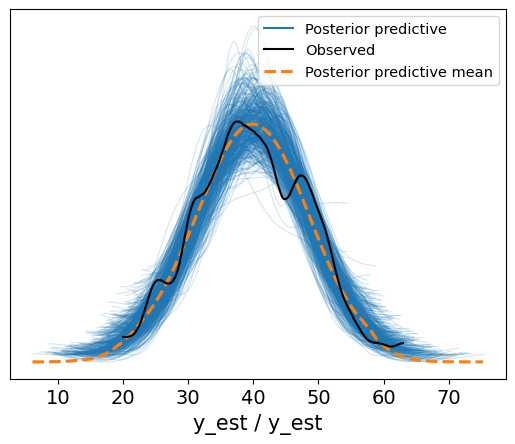

In [ ]:
az.plot_ppc(multi_ppc,
            num_pp_samples = 500)

### 评估后验预测

#### MAE

$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [ ]:
from statistics import median

# 提取出所有的后验预测值，每一个X对应4*5000个Y的后验预测值，使用stack汇总到一起
multipre_x = multi_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))

#对每一个X，计算其Y的后验预测均值
multipre_y_mean = multipre_x.mean(axis=1).values

# 提取对应的观测值、后验预测均值，存放在一个表格中
multipre_y_mean = pd.DataFrame({
    "scontrol_ppc_mean": multipre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
multipre_y_mean["pre_error"] = multipre_y_mean["scontrol_original"] -\
                                multipre_y_mean["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_multi = median(multipre_y_mean.pre_error)
print(f"计算得到的MAE: {MAE_multi:.2f}")

计算得到的MAE: 0.04


#### 后验预测区间

* 使用`az.summary`，可以直接得到每个Y后验预测值94%的可信区间
* 将真实数据与其合并，判断其是否在对应的94%可信区间内，并进行绘图

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [ ]:
az.summary(multi_ppc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_est[0],40.684,7.052,27.695,54.063,0.051,0.036,19382.0,19449.0,1.0
y_est[1],34.989,7.176,21.288,48.112,0.052,0.037,19316.0,19029.0,1.0
y_est[2],42.129,7.102,28.585,55.421,0.050,0.035,20364.0,19440.0,1.0
y_est[3],38.306,7.110,24.650,51.474,0.051,0.036,19445.0,19219.0,1.0
y_est[4],43.978,7.112,30.366,57.139,0.050,0.035,20292.0,20110.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[176],38.912,7.083,26.103,52.787,0.051,0.036,19157.0,20143.0,1.0
y_est[177],43.182,7.046,29.954,56.526,0.050,0.036,19700.0,19449.0,1.0
y_est[178],40.705,7.138,27.281,54.041,0.051,0.036,19399.0,19599.0,1.0
y_est[179],38.932,7.067,25.449,51.869,0.050,0.036,19787.0,19573.0,1.0


In [ ]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_multi = az.summary(multi_ppc)
hdi_multi = hdi_multi.reset_index()

# 将原数据中的压力分数与自我控制分数合并，便于后续进行判断
hdi_multi["x_obs"] = multi_ppc.constant_data["stress"].values
hdi_multi["y_obs"] = multi_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_multi["verify"] = np.where((hdi_multi["y_obs"] >= hdi_multi["hdi_3%"]) & (hdi_multi["y_obs"] <= hdi_multi["hdi_97%"]), 
                  0, 1)
hdi_multi_num = sum(hdi_multi["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_multi_num}")

所有超过后验预测范围HDI的数量: 9


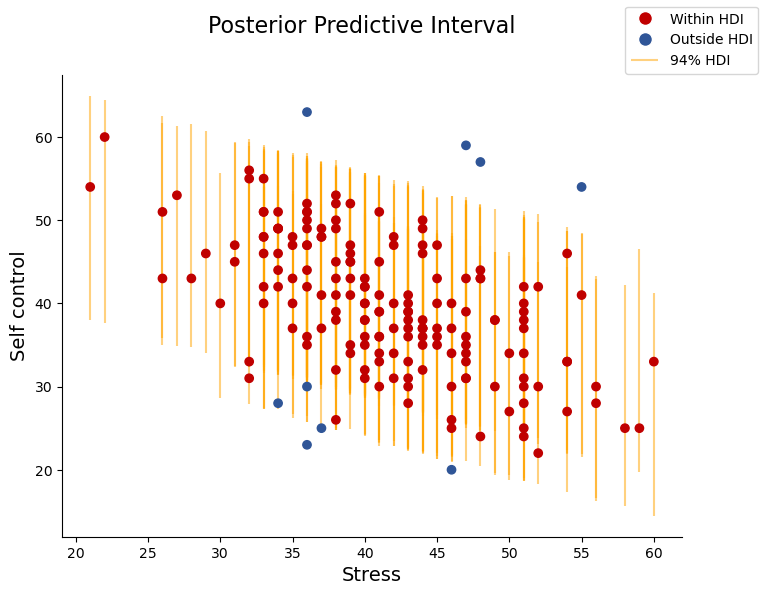

In [ ]:
fig, ax =  plt.subplots(figsize=(8,6))

# 绘制94%的可信区间
HDI = ax.vlines(hdi_multi["x_obs"], 
          hdi_multi["hdi_3%"], hdi_multi["hdi_97%"], 
          color="orange", 
          alpha=0.5,
          label="94% HDI")

#绘制真实值的散点图，并根据是否落在区间内设置观测值的不同颜色
colors = np.where((hdi_multi["y_obs"] >= hdi_multi["hdi_3%"]) & (hdi_multi["y_obs"] <= hdi_multi["hdi_97%"]), 
                  '#C00000', '#2F5597')
ax.scatter(hdi_multi["x_obs"], hdi_multi["y_obs"],
           c = colors,
           zorder = 2)

# 设置图例的颜色、形状、名称
legend_color = ['#C00000','#2F5597']
handles = [plt.Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor=color, markersize=10) for color in legend_color]
handles += [HDI]
labels = ['Within HDI', 'Outside HDI','94% HDI']

# 设置坐标轴名称、标题
ax.set_xlabel('Stress', fontsize=14) 
ax.set_ylabel('Self control', fontsize=14)
fig.legend(handles=handles, labels=labels, loc='outside upper right')
fig.suptitle('Posterior Predictive Interval', fontsize=16)
sns.despine()


## 增加交互项

* **交互作用：** 存在两个或两个以上自变量时，其中，自变量$X_1$对因变量$Y$的影响在自变量$X_2$的不同水平上有所差异
    
    * 在本例中，我们可以假设，在不同的吸烟状况下，压力对自我控制的影响略有不同(体现在斜率上) 

![Image Name](https://cdn.kesci.com/upload/s4baxp7vsh.png?imageView2/0/w/960/h/960)

那么我们可以加入交互项：$\mu = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{1}X_{2}  $

$$
\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1}X_{i2} \\
\text{priors:} & & \beta_{0c}  &  \sim N\left(60, 2^2 \right)  \\
                     & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\
                     & & \beta_2  & \sim N\left(-10, 4^2 \right) \\
                     & & \beta_3  & \sim N\left(0, 0.8^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}
\end{equation}
$$

**在这个例子中，各参数的意义：**

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1} = (\beta_0 +\beta_2) + (\beta_1 + \beta_3)X_{i1}$

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况
    * 注意截距项和斜率项的变化
    * 此时压力对自我控制的影响为$(\beta_1 + \beta_3)$，体现了吸烟对这一关系的影响

* 这里我们还是根据经验定义先验中的超参

**直接运行模型定义、MCMC采样、后验预测部分**

In [ ]:
with pm.Model() as interaction_model:
    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=-10, sigma=4)         #定义beta_2
    beta_3 = pm.Normal("beta_3", mu=0, sigma=0.8)         #定义beta_3
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    stress = pm.MutableData("stress",df_METU.stress, dims="obs_id")      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")         #smoke是自变量吸烟水平
    mu = pm.Deterministic("mu", beta_0 + 
                                beta_1*stress + 
                                beta_2*smoke +
                                beta_3*stress*smoke, dims="obs_id")      #定义mu，将自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                                    #通过 observed 传入实际数据y 自我控制水平

In [ ]:
with interaction_model:
    interaction_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                       tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                       chains=4,                     # 链数
                                       discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                       random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 121 seconds.


In [ ]:
with interaction_model:
    interaction_ppc = pm.sample_posterior_predictive(interaction_regression,
                                                     random_seed=84735)

Sampling: [y_est]


### 可视化后验预测结果

#### 后验预测的线性模型

我们可以分别查看不同吸烟情况下，压力对自我控制的预测情况

1. 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$：不吸烟情况下，自我控制分数随压力分数变化的情况

2. 当$X_{i2} = 1$时，$\mu_i = (\beta_0 +  \beta_2) + (\beta_1 + \beta_3)X_{i1}$：吸烟情况下，自我控制分数随压力分数变化的情况

* 根据吸烟情况($X_{i2} = 0/1$)，将后验参数的预测值分成两部分

* 代入公式，$\mu = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i1}X_{i2}$，获得对应的后验预测均值



In [ ]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df_METU.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df_METU.query("smoke == 1")["stress"])["index"].values

In [ ]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
in_nosmoke_para = interaction_regression.sel(obs_id=no_smoke_index)
in_smoke_para = interaction_regression.sel(obs_id=smoke_index)

* 查看 `in_nosmoke_para`:`constant_data`中的`smoke`值全为0，表明已经根据吸烟情况将后验预测数据分成了两份

In [ ]:
in_nosmoke_para

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [ ]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
in_nosmoke_para.posterior["y_model"] = in_nosmoke_para.posterior["beta_0"] +\
                                    in_nosmoke_para.posterior["beta_1"] * in_nosmoke_para.constant_data["stress"] +\
                                    in_nosmoke_para.posterior["beta_2"] * in_nosmoke_para.constant_data["smoke"] +\
                                    in_nosmoke_para.posterior["beta_3"] * in_nosmoke_para.constant_data["smoke"] * in_nosmoke_para.constant_data["stress"]


In [ ]:
# 在吸烟情况下，将参数与自变量进行组合，生成回归线
in_smoke_para.posterior["y_model"] = in_smoke_para.posterior["beta_0"] +\
                                    in_smoke_para.posterior["beta_1"] * in_smoke_para.constant_data["stress"] +\
                                    in_smoke_para.posterior["beta_2"] * in_smoke_para.constant_data["smoke"] +\
                                    in_smoke_para.posterior["beta_3"] * in_smoke_para.constant_data["smoke"] * in_smoke_para.constant_data["stress"]


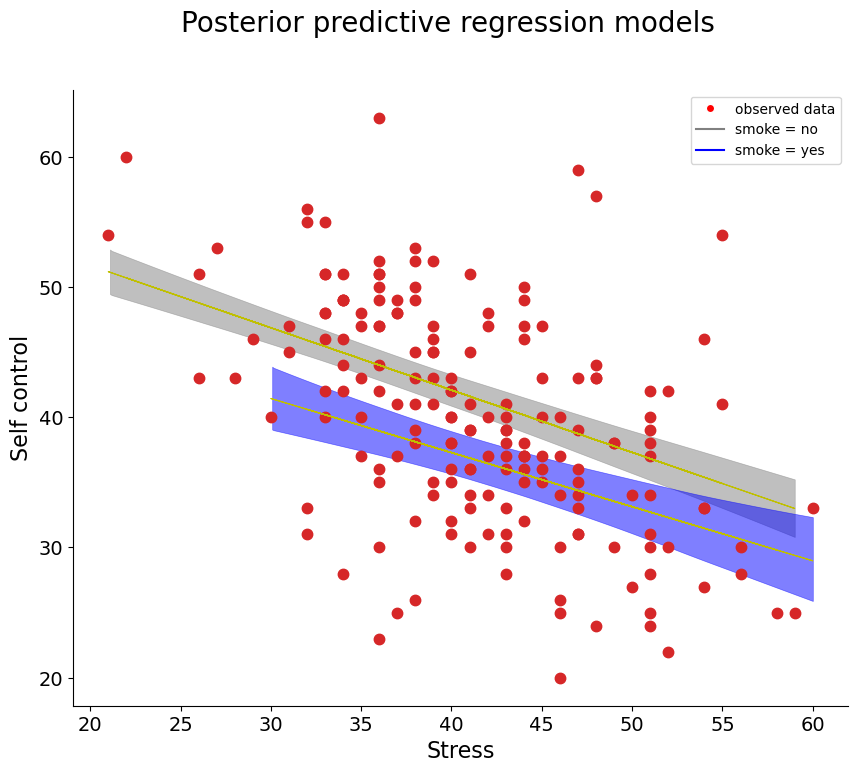

In [ ]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=in_nosmoke_para,
           y= "y_est",
           x= "stress",
           y_model = in_nosmoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=in_smoke_para,
           y= "y_est",
           x= "stress",
           y_model = in_smoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_model_fill_kwargs = {"color":"blue"})

#设置标题、坐标轴标题

axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Self control', fontsize=16) 

#设置图例
handles = [plt.Line2D([0], [0],
                      marker ='o',
                      color='w', 
                      markerfacecolor='red', 
                      label = 'observed data'),
           plt.Line2D([], [], color="grey",
                      label = 'smoke = no'),
           plt.Line2D([], [], color="blue",
                      label = 'smoke = yes')]

axes.legend(handles=handles)

#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14) 
 
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

* 我们可以将有交互项和无交互项两种模型生成的回归线进行对比：

![Image Name](https://cdn.kesci.com/upload/s4b4rk25wv.png?imageView2/0/w/960/h/960)


#### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

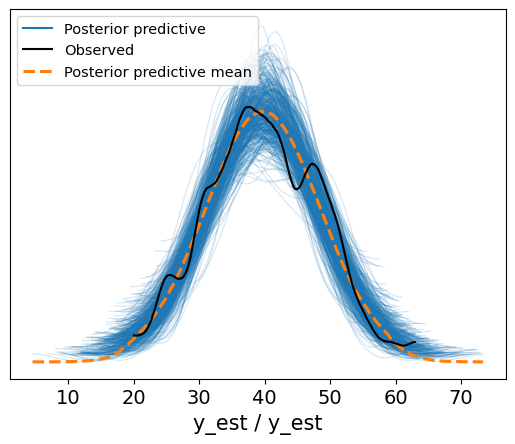

In [ ]:
az.plot_ppc(interaction_ppc, num_pp_samples=500)

### 评估后验预测

#### MAE

$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [ ]:
from statistics import median

# 提取出所有的后验预测值，每一个X对应4*5000个Y的后验预测值，使用stack汇总到一起
interpre_x = interaction_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))

#对每一个X，计算其Y的后验预测均值
interpre_y_mean = interpre_x.mean(axis=1).values

# 提取对应的观测值、后验预测均值，存放在一个表格中
interpre_y_mean = pd.DataFrame({
    "scontrol_ppc_mean": interpre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
interpre_y_mean["pre_error"] = interpre_y_mean["scontrol_original"] -\
                                interpre_y_mean["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_interaction = median(interpre_y_mean.pre_error)
print(f"计算得到的MAE: {MAE_interaction:.2f}")

计算得到的MAE: 0.17


#### 后验预测区间

* 使用`az.summary`，可以直接得到每个Y后验预测值94%的可信区间
* 将真实数据与其合并，判断其是否在对应的94%可信区间内，并进行绘图

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [ ]:
az.summary(interaction_ppc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_est[0],40.591,7.059,27.203,53.602,0.051,0.036,19441.0,19722.0,1.0
y_est[1],35.198,7.188,22.300,49.232,0.052,0.037,19247.0,19298.0,1.0
y_est[2],42.053,7.107,28.469,55.275,0.050,0.035,20389.0,19505.0,1.0
y_est[3],38.175,7.132,24.579,51.454,0.051,0.036,19475.0,18802.0,1.0
y_est[4],43.934,7.121,30.622,57.391,0.050,0.035,20368.0,20100.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[176],38.786,7.098,24.868,51.601,0.051,0.036,19117.0,19973.0,1.0
y_est[177],43.119,7.058,30.470,57.127,0.050,0.036,19713.0,19639.0,1.0
y_est[178],40.604,7.146,27.346,54.178,0.050,0.036,20068.0,19683.0,1.0
y_est[179],38.811,7.096,25.062,51.692,0.050,0.036,19821.0,19416.0,1.0


In [ ]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_interaction = az.summary(interaction_ppc)
hdi_interaction = hdi_interaction.reset_index()

# 将原数据中的压力分数与自我控制分数合并，便于后续进行判断
hdi_interaction["x_obs"] = interaction_ppc.constant_data["stress"].values
hdi_interaction["y_obs"] = interaction_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_interaction["verify"] = np.where((hdi_interaction["y_obs"] >= hdi_interaction["hdi_3%"]) & (hdi_interaction["y_obs"] <= hdi_multi["hdi_97%"]), 
                  0, 1)
hdi_interaction_num = sum(hdi_interaction["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_interaction_num}")

所有超过后验预测范围HDI的数量: 9


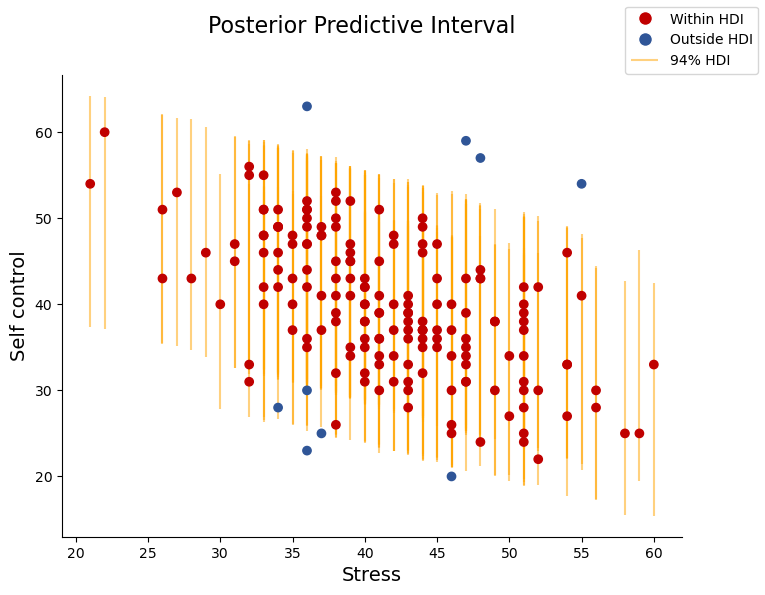

In [ ]:
fig, ax =  plt.subplots(figsize=(8,6))

# 绘制94%的可信区间
HDI = ax.vlines(hdi_interaction["x_obs"], 
          hdi_interaction["hdi_3%"], hdi_interaction["hdi_97%"], 
          color="orange", 
          alpha=0.5,
          label="94% HDI")

#绘制真实值的散点图，并根据是否落在区间内设置观测值的不同颜色
colors = np.where((hdi_interaction["y_obs"] >= hdi_interaction["hdi_3%"]) & (hdi_interaction["y_obs"] <= hdi_multi["hdi_97%"]), 
                  '#C00000', '#2F5597')
ax.scatter(hdi_interaction["x_obs"], hdi_interaction["y_obs"],
           c = colors,
           zorder = 2)

# 设置图例的颜色、形状、名称
legend_color = ['#C00000','#2F5597']
handles = [plt.Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor=color, markersize=10) for color in legend_color]
handles += [HDI]
labels = ['Within HDI', 'Outside HDI','94% HDI']

# 设置坐标轴名称、标题
ax.set_xlabel('Stress', fontsize=14) 
ax.set_ylabel('Self control', fontsize=14)
fig.legend(handles=handles, labels=labels, loc='outside upper right')
fig.suptitle('Posterior Predictive Interval', fontsize=16)
sns.despine()


## 总结模型后验预测表现情况

In [ ]:
summary_MAE_interval = pd.DataFrame({"model_name":["category_model","multi_linear_model","interaction_model"],
                                    "MAE":[MAE_cat,MAE_multi,MAE_interaction],
                                    "HDI_num":[hdi_cat_num,hdi_multi_num,hdi_interaction_num]})

summary_MAE_interval 

,model_name,MAE,HDI_num
0,category_model,-1.268343,10
1,multi_linear_model,0.042424,9
2,interaction_model,0.166760,9


## 模型评估与比较 (Model evaluation & comparison)

关于自我控制的主题，我们已经探索了多种研究假设和多个模型，你可能想知道哪个是最好的模型？

模型评估与比较(Model evaluation & comparison)的目的在于选择最好的模型。

什么需要模型比较？
1. 例如，比较 mode4 和 model3 可以帮助我们确定压力和吸烟之间的交互或调节作用。
2. 例如，比较 model3 和 model2(或model1) 可以衡量增加预测因子是否能提升模型的预测能力。
- 总之，模型比较的目的随着研究目的变化而变化。

|模型|参数|解释|
|-|-|-|
|model1|scontrol ~ stress|一般线性回归模型：自变量和因变量均为连续变量|
|model2|scontrol ~ smoke|一般线性回归模型：自变量为离散变量|
|model3|scontrol ~ stress + smoke|多元回归模型：自变量为连续变量和离散变量的组合|
|model4|scontrol ~ stress + smoke + stress:smoke|多元回归模型：自变量额外增加了两个自变量间的交互或调节作用|

### 模型评估的绝对指标和相对指标

在上节课，我们讨论了三种评价模型的视角：
- 公平性(How fair)：模型在数据收集和分析的整个流程中的公正性。
- 错误程度(How wrong)：模型在**实践**中是否有效？即是否能够准确地预测**样本**数据。
- 准确性(How accurate)：模型是否反映**现实规律**？即是否能够准确地预测**样本外**数据。

而之前课程所讨论的评估标准(MAE和后验预测区间)都是**绝对指标**，即评估模型在**样本**数据上的预测能力。

而**相对指标**更多的是评估模型在**样本外**数据上的，这更有利于比较不同模型的预测能力。

**模型评估：对新数据的预测准确性**

为了评估模型对**样本外数据**的预测能力，我们有以下3种策略：
1. 通过新数据对模型进行评估。我们可以收集新的数据，并检验模型的预测能力。
2. 从已有样本中拿出一部分数据用来预测，这被称为**交叉验证(cross validation)** 方法。
3. 交叉验证的近似方法。例如，使用对交叉验证近似的**信息熵指标**来评估模型对样本外数据的预测能力。

根据第一种策略收集新数据来检验模型的预测能力是一种理所当然的直觉。该策略包括两个主要步骤：
1. 训练模型：
   -  首先，我们根据现有的数据训练一个模型。如之前的例子，我们可以训练用压力和吸烟预测自我控制的线性模型。
2. 测试模型：
   -  在这阶段，我们需要收集新的数据，并检验模型的预测能力。例如，我们可以将新数据中测量的压力和吸烟数据带入模型，从而获得对于新数据的后验预测数据。最后，计算后验预测数据与新数据的MAE，从而评估模型对样本外数据的预测能力。

但心理学数据不同于其他学科的数据，它常受到**时间因素**和**抽样**的影响。
- 比如，个体的压力状态可能随着季节变化，因此在不同季节收集到的数据会受到时间的影响。
- 又例如，训练模型的数据来自理工科的学生，而测试模型的数据来自心理学的学生。这样抽样的差异也会影响模型对样本外数据的预测能力。

因此，一种更高效的方法是，一次性多收集一些数据，选择其中的一部分作为预测数据。

### 交叉验证(cross validation)

但问题在于，我们选择哪一部分数据作为预测数据呐？或者说，我们该如何有效的对数据进行抽取呐？

**交叉验证(cross validation)** 的目的就在于：提供不同的抽取预测数据的策略
- 其关键在于从已有样本中拿出一部分数据当作预测数据。


![](https://pic1.zhimg.com/80/v2-e9ad5ba61cda7ebd02848f336607eb70_1440w.webp)


> 资料来源：【绝对干货】机器学习模型训练全流程！- 知乎 https://zhuanlan.zhihu.com/p/184673895

常见的交叉验证策略：
1. 分半交叉验证 (Split-half cross-validation)
	- 分半交叉验证将观测数据对半分成两部分，分别在不同的数据集上拟合模型，并在另外一半数据集上验证模型，最后再对比不同的模型在两份数据集作为验证集时的预测准确度。
2. K 折交叉验证 (K-fold cross-validation) 
	- K 折交叉验证把数据分成 K 分，其中一份作为训练集（拟合模型，对参数进行估计），其余的 K-1 分数据集作为验证集，总共重复这个流程 K 次。以 K 次验证结果的均值作为验证标准。
3. 留一法交叉验证 (Leave-one-out cross-validation)
	- 留一法交叉验证是 K 折交叉验证的一个特例，当分折的数量等于数据的数量时，K 折留一法便成了留一法交叉验证。留一法交叉验证相较于普通的交叉验证方法，几乎使用了所有数据去训练模型，因此留一法交叉验证的训练模型时的**偏差 (bias) 更小、更鲁棒**，但是又因为验证集只有一个数据点，验证模型的时候**留一法交叉验证的方差 (Variance) 也会更大**。

**K 折交叉验证 (K-fold cross-validation)**

K 折交叉验证在分半交叉验证的基础上，将数据集分成 K 份(称为 CV-K)，其中一份作为测试集，其余 K-1 份作为训练集，重复这个流程 K 次。

K 折交叉验证，以 K 次测试结果的**均值**作为验证标准。例如，在压力-自我控制的例子中：
- 我们可以使用 K=5 折的交叉验证，将数据集分成 5 份，每次使用 5 份数据作为训练集，1份数据作为测试集。
- 对每一次迭代，我们使用 5 份数据训练模型，然后使用剩下的一份数据进行测试，并计算相应的MAE。
- 重复这个流程 5 次，然后取每次MAE测试结果的均值作为最终的测试结果。

![](https://pic3.zhimg.com/80/v2-ff846ee7eefdcd425e123d9d31b4d58a_1440w.webp)

> 资料来源：【绝对干货】机器学习模型训练全流程！- 知乎 https://zhuanlan.zhihu.com/p/184673895

**留一法交叉验证 (Leave-one-out cross-validation)**

留一法交叉验证是 K 折交叉验证的一个特例，当分折的数量K等于数据的数量n时，K 折留一法便成了留一法交叉验证。
- 留一法交叉验证相较于普通的交叉验证方法，几乎使用了所有数据去训练模型。
- 留一法交叉验证 (Leave-one-out cross-validation)的缩写为 loo-cv，或者 loo。

![](https://www.baeldung.com/wp-content/uploads/sites/4/2022/05/loso.png)

> 资料来源：https://www.baeldung.com/cs/cross-validation-k-fold-loo

### ELPD (Expected log-predictive density)

留一法交叉验证 LOO (包括之前的交叉验证方法)是用于评估模型在**未知数据**上预测能力的思想框架，其本身并不提供具体的统计指标。

**ELPD** (Expected log-predictive density) 是 LOO 方法的具体实现，以对数似然函数作为统计指标。

其计算步骤：
- 同 K 折交叉验证一样，首先将数据集分成 n 份，n为数据总的数量。
- 利用 n-1 份数据去训练模型，得到后验模型 $p(\theta_{-i}|y_{-i})$。
- 使用剩下的一份数据作为测试数据 $y_{i}$，计算后验预测模型 $p(y_{i}|y_{-i})$。
- 重以上过程，重复 n 次，得到 n 个后验预测模型,并计算其对数化后的期望值 $E(log(p(y_{i}|y_{-i})))$。

![Image Name](https://cdn.kesci.com/upload/image/rkvl0j94s7.png?imageView2/0/w/640/h/640)

在实际操作中，我们通过 `ArViz` 的函数`az.loo`计算 $ELPD_{LOO-CV}$。

* 在`az.loo`返回的值中，`elpd_loo` 为$E(log(p(y_{i}|y_{-i})))$，
* `elpd_loo`越高表示模型的预测值越精确

注意：由于 $ELPD_{LOO-CV}$ 的计算量也比较大，ArViz 会使用 Pareto Smooth Importance Sampling Leave Once Out Cross Validation (PSIS-LOO-CV) 来近似 $ELPD_{LOO-CV}$。

PSIS-LOO-CV 有两大优势：
1. 计算速度快，且结果稳健
2. 提供了丰富的模型诊断指标

In [ ]:
az.loo(trace)

Computed from 20000 posterior samples and 174 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -545.76     9.54
p_loo        2.72        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      174  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

`elpd_loo`的结果为-545.76

- 然而，仅凭单个值，并不能反映模型的预测精确程度。
- 虽然 **ELPDs 无法为任何单一模型的后验预测准确性提供可解释的度量，但它在比较多个模型的后验预测准确性时非常有用**。

In [ ]:
az.compare()

🤔思考：

1. 如果您的目标是在不控制任何其他因素的情况下探索 temp3pm 与地点之间的关系，您会使用哪种模型？
    
    - 天气模型 2 是最好的--它是唯一一个研究了我们感兴趣的确切关系（temp3pm 与地点的关系）的模型。
        
2. 如果您的目标是最大限度地提高模型的预测质量，而在模型中**只能选择一个预测因子，您会选择 temp9am 还是 location？**
    
    - 我们只能选择一个预测因子，那么天气模型_1 似乎是最好的。也就是说，仅用上午 9 点预测下午 3 点似乎比仅用地点预测下午 3 点更好。
        
3. 这四个模型中，哪个模型的**总体预测结果**最好？
    - weather_model_3 似乎以微弱优势**超过了使用全部五个预测因子的模型（weather_model_4）**。在建立模型的过程中，并不是越多越好。事实上，weather_model_4 的预测误差更大，这表明如果我们已经掌握了上午 9 点的温度和位置信息，那么它所增加的三个预测因子（上午 9 点的风速、上午 9 点的湿度和上午 9 点的气压）并不能大幅提高我们对下午 3 点的理解。
   - 因此，为了简单高效，我们很乐意选择较小的 weather_model_3。

总结：

模型拟合优度的方法包括：
- 拟合优度 
- mse 
- 对数似然

模型预测进度的方法包括：
- AIC
- DIC
- WAIC
- LOO

模型平均法包括：
- Bayesian model averaging
- BIC
- Pseudo Bayesian model averaging

|                    | AIC                                  | DIC                                      | WAIC       | LOOCV           | BIC                                  |
| ------------------ | ------------------------------------ | ---------------------------------------- | ---------- | --------------- | ------------------------------------ |
| 适用框架           | 频率论                               | 贝叶斯                                   | 贝叶斯     | 贝叶斯          | 贝叶斯/频率论                        |
| 偏差（deviance）   | 最大似然参数 $\theta_mle$ 的对数似然 | 贝叶斯参数均值 $\bar{\theta}$ 的对数似然 | LPPD       | $ELPD_{LOO-CV}$ | 最大似然参数 $\theta_mle$ 的对数似然 |
| 矫正（correction） | 参数数量                             | 似然的变异                               | 似然的变异 |     由于采用 LOO-CV 思想，因此不需要矫正            | 参数数量+数据数量                    |

## 偏差方差权衡(bias-variance trade-off)

模型评估的核心在于模型捕捉到了数据中的关键模式，既非太简单而错过数据中有价值的信息(**欠拟合, underfitting**)，也不会太复杂从而将数据中的噪音加入到模型中(**过拟合, overfitting**)。

**欠拟合(underfitting)**

* 欠拟合的模型在当前样本的数据拟合效果不好，且其泛化能力(模型在当前样本外新的数据上的预测的准确度)也同样不佳。
* 导致欠拟合的原因
  * 数据特征较少
    * 数据特征指的是数据的属性，比如第一部分中展示的数据的各个变量就是数据的特征。在所有变量都能独立地对目标变量做出解释的前提下，数据特征越多，数据拟合程度越好。
  * 模型复杂度过低
    * 模型的复杂度代表模型能够描述的所有函数，比如线性回归最多能表示所有的线性函数。
    * 模型的复杂度和模型的参数数量有关，一般来说，模型参数越多，复杂度越高，模型参数越少，复杂度越低。

**过拟合(overfitting)**

* 模型在当前样本的数据上的拟合程度极好，但是泛化能力也较差。
* 模型把训练样本学习地“太好了”，把样本自身地一些噪音也当作了所有潜在样本都会具有的一些性质，这样就会导致其泛化性能下降。
* 导致过拟合的原因
  * 当前样本的噪音过大，模型将噪音当作数据本身的特征
  * 当数据的有些特征与目标变量无关，这些特征就是噪音，但它也可能被误当作数据特征，这就会造成模型过拟合
  - 样本选取有误，样本不能代表整体
  - 模型参数太多，模型复杂度太高

![Image Name](https://img-blog.csdnimg.cn/20210303141100499.png#pic_center)

资料来源：https://blog.csdn.net/weixin_43378396/article/details/90707493


![Image Name](https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity-768x443.png)

资料来源：https://vitalflux.com/overfitting-underfitting-concepts-interview-questions/

### 如何避免欠拟合

- 增加数据的特征

- 增加模型复杂度

### 如何避免过拟合

- 选择更具代表性的数据

- 降低模型复杂度


**问题的本质在于：模型与数据真实的生成模型匹配**

为了选择一个能够在过拟合和欠拟合之间的达到平衡的最佳模型，就需要进行模型评估、比较和选择。

## workflow

![Image Name](https://cdn.kesci.com/upload/image/rkz1dqyo2e.png?imageView2/0/w/960/h/960)

**概念区别：模型诊断(model diagnostic) vs. 模型验证(model validation)**

在贝叶斯的workflow中，

- MCMC评估是对MCMC进行检验，在Gelman et al (2020)中也被称为计算过程的验证(validate computation)，其核心在于确定MCMC算法采样得到的样本是否足以提供目标分布的精确近似。

- 模型评估则是指对模型是否公平性、有效性、可信性进行评估，既可以是对单个模型，也可以是对多个模型进行。

理想情况下，两种评估结果都是良好的。然而，情况并非总是如此。
  - 我们可能有一个很好的模型框架，但是MCMC链的结果却不稳定，进而导致不准确的后验近似。
  - 或者刚好相反，我们可以获得很好地后验近似，但模型本身却并不反映任何事实。

## 总结



**如何增加后验预测的能力？**

往往有两种通用的策略：
- 收集更多的数据：
    - 虽然收集更多的数据并不能改变 Y 和 X 之间潜在的微弱关系，但它可以改善模型对参数后验的估计，从而改进模型的后验预测。
    - 一些可以考虑的手段，增加数据量(n)，扩大x的范围，扩大后验预测的范围。
- 加入更多的预测变量：  
    - 例如，在自我控制能力方面，压力比吸烟有更好的预测。
    - 此外，我们可以通过加入 2 个或更多的预测因子来改进我们的模型及其对 Y 的预测（即同时将压力和吸烟作为预测因子加入模型）。

至此，我们对贝叶斯分析的全流程(Bayesian workflow)有了一个初步的认识，之后的课程中，我们会不断实践这个流程，让大家感受贝叶斯分析的魅力。

![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/960/h/960)
